In [6]:
from pathlib import Path
import pandas as pd

AG_PATH = Path("/content/drive/MyDrive/AMDA/training_data.csv")
assert AG_PATH.exists(), f"Nu găsesc fișierul: {AG_PATH.resolve()}"

ag = pd.read_csv(AG_PATH)
ag.head()


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [7]:
print(ag.info())
print("\nColoane:", list(ag.columns))

print("\nDistribuția label-urilor:")
print(ag['label'].value_counts())


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 120000 entries, 0 to 119999
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    120000 non-null  object
 1   label   120000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 1.8+ MB
None

Coloane: ['text', 'label']

Distribuția label-urilor:
label
2    30000
3    30000
1    30000
0    30000
Name: count, dtype: int64


In [8]:
ag['text_len'] = ag['text'].astype(str).str.split().apply(len)
print("\nStatistici lungime text (număr de cuvinte):")
print(ag['text_len'].describe())

ag[['text','label']].head(5)



Statistici lungime text (număr de cuvinte):
count    120000.000000
mean         37.847450
std          10.085245
min           8.000000
25%          32.000000
50%          37.000000
75%          43.000000
max         177.000000
Name: text_len, dtype: float64


,text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,2
4,"Oil prices soar to all-time record, posing new...",2


In [9]:
!pip install wordcloud


KeyError: 'clean_text'

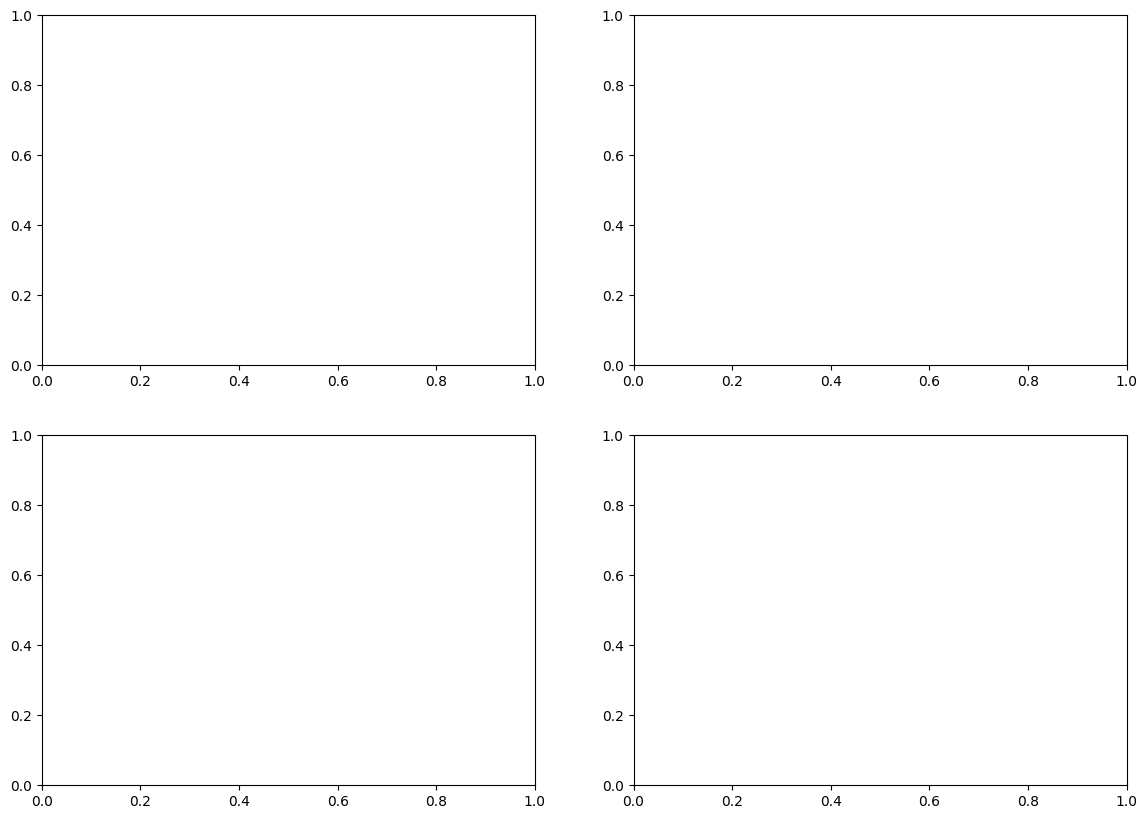

In [10]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# dictionary: label -> label name
label_names = {
    0: "World",
    1: "Sports",
    2: "Business",
    3: "Sci/Tech"
}

# Adjust figure layout
fig, axes = plt.subplots(2, 2, figsize=(14, 10))
axes = axes.flatten()

for label, ax in zip(sorted(label_names.keys()), axes):
    # select all texts from category
    text_data = ag[ag['label'] == label]['clean_text']

    # concatenate them into one big string
    full_text = " ".join(text_data)

    # generate wordcloud
    wc = WordCloud(
        width=800,
        height=400,
        background_color="white",
        max_words=200,
        colormap="viridis"
    ).generate(full_text)

    ax.imshow(wc, interpolation='bilinear')
    ax.set_title(f"WordCloud – {label_names[label]}", fontsize=16)
    ax.axis('off')

plt.tight_layout()
plt.show()


In [11]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import re

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

stop_words = set(stopwords.words('english'))
negations = {"not", "no", "nor", "never", "n't"}
stop_words = {w for w in stop_words if w not in negations}

lemmatizer = WordNetLemmatizer()

def clean_text(text: str, do_stop=True, do_lemma=True):
    text = text.lower()
    text = re.sub(r'https?://\S+|www\.\S+', ' ', text)
    text = re.sub(r'[^a-z\s]', ' ', text)
    tokens = text.split()
    if do_stop:
        tokens = [t for t in tokens if t not in stop_words]
    if do_lemma:
        tokens = [lemmatizer.lemmatize(t) for t in tokens]
    return " ".join(tokens)

# dacă nu ai deja coloana:
if 'clean_text' not in ag.columns:
    ag['clean_text'] = ag['text'].astype(str).apply(lambda s: clean_text(s, True, True))

ag[['text','clean_text','label']].head(5)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


,text,clean_text,label
0,Wall St. Bears Claw Back Into the Black (Reute...,wall st bear claw back black reuters reuters s...,2
1,Carlyle Looks Toward Commercial Aerospace (Reu...,carlyle look toward commercial aerospace reute...,2
2,Oil and Economy Cloud Stocks' Outlook (Reuters...,oil economy cloud stock outlook reuters reuter...,2
3,Iraq Halts Oil Exports from Main Southern Pipe...,iraq halt oil export main southern pipeline re...,2
4,"Oil prices soar to all-time record, posing new...",oil price soar time record posing new menace u...,2


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.metrics import (
    accuracy_score, classification_report,
    precision_recall_fscore_support
)

def run_experiment_mc(
    text_series,
    labels,
    vec_type='count',
    max_features=5000,
    ngram_range=(1,1),
    model_type='multinomial',
    alpha=1.0,
    test_size=0.2,
    random_state=42
):
    # 1. split pe text brut
    X_train_text, X_test_text, y_train, y_test = train_test_split(
        text_series.astype(str).values,
        labels.values,
        test_size=test_size,
        random_state=random_state,
        stratify=labels.values
    )

    # 2. vectorizare
    if vec_type == 'count':
        vectorizer = CountVectorizer(
            max_features=max_features,
            ngram_range=ngram_range
        )
    elif vec_type == 'tfidf':
        vectorizer = TfidfVectorizer(
            max_features=max_features,
            ngram_range=ngram_range
        )
    else:
        raise ValueError("vec_type must be 'count' or 'tfidf'.")

    X_train = vectorizer.fit_transform(X_train_text)
    X_test  = vectorizer.transform(X_test_text)

    # 3. model
    if model_type == 'multinomial':
        model = MultinomialNB(alpha=alpha)
    elif model_type == 'bernoulli':
        model = BernoulliNB(alpha=alpha)
    else:
        raise ValueError("Unsupported model_type")

    model.fit(X_train, y_train)

    # 4. metrici
    y_pred = model.predict(X_test)

    acc = accuracy_score(y_test, y_pred)
    prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
        y_test, y_pred, average='macro', zero_division=0
    )
    f1_weighted = precision_recall_fscore_support(
        y_test, y_pred, average='weighted', zero_division=0
    )[2]

    cls_report = classification_report(y_test, y_pred, digits=4)

    return {
        "acc": acc,
        "precision_macro": prec_macro,
        "recall_macro": rec_macro,
        "f1_macro": f1_macro,
        "f1_weighted": f1_weighted,
        "cls_report": cls_report,
        "model": model,
        "vectorizer": vectorizer
    }


In [13]:
res_AG_A1 = run_experiment_mc(
    text_series=ag['clean_text'],
    labels=ag['label'],
    vec_type='count',
    max_features=5000,
    ngram_range=(1,1),
    model_type='multinomial',
    alpha=1.0
)

print({
    'Accuracy': round(res_AG_A1['acc'], 4),
    'Precision_macro': round(res_AG_A1['precision_macro'], 4),
    'Recall_macro': round(res_AG_A1['recall_macro'], 4),
    'F1_macro': round(res_AG_A1['f1_macro'], 4),
    'F1_weighted': round(res_AG_A1['f1_weighted'], 4),
})

print("\nClassification report – AG_A1 (Count, unigrams):\n")
print(res_AG_A1['cls_report'])


{'Accuracy': 0.898, 'Precision_macro': 0.8975, 'Recall_macro': 0.898, 'F1_macro': 0.8976, 'F1_weighted': 0.8976}

Classification report – AG_A1 (Count, unigrams):

              precision    recall  f1-score   support

           0     0.9040    0.8887    0.8963      6000
           1     0.9374    0.9727    0.9547      6000
           2     0.8767    0.8580    0.8673      6000
           3     0.8719    0.8725    0.8722      6000

    accuracy                         0.8980     24000
   macro avg     0.8975    0.8980    0.8976     24000
weighted avg     0.8975    0.8980    0.8976     24000



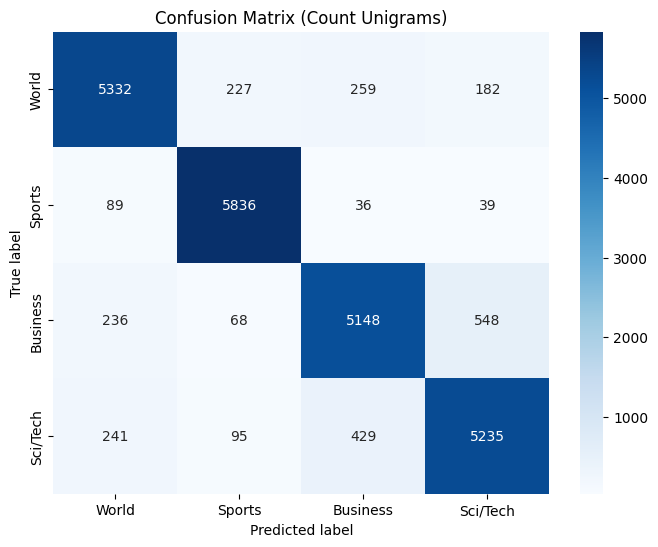

In [27]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# 1. Reconstruim X_train și X_test
X = ag['clean_text'].astype(str).values
y = ag['label'].values

X_train_text, X_test_text, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# 2. Vectorizăm folosind EXACT vectorizatorul din experiment
vectorizer = res_AG_A1['vectorizer']
X_test_vec = vectorizer.transform(X_test_text)

# 3. Predictii cu modelul salvat
model = res_AG_A1['model']
y_pred = model.predict(X_test_vec)

# 4. Matricea de confuzie
cm = confusion_matrix(y_test, y_pred)

labels = ["World", "Sports", "Business", "Sci/Tech"]

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=labels, yticklabels=labels)

plt.title("Confusion Matrix (Count Unigrams)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


In [22]:
# =============================
# 1. Importuri
# =============================
import pandas as pd
import numpy as np
import re
import nltk

from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report
)

nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

stop_words = set(stopwords.words("english"))
lemmatizer = WordNetLemmatizer()


# =============================
# 2. Încarcare dataset
# =============================
train = pd.read_csv("/content/drive/MyDrive/AMDA/training_data.csv")   # schimbă path dacă ai alt folder

print("Train shape:", train.shape)
print(train.head())


# =============================
# 3. Preprocesare text
# =============================
def clean_text(s):
    s = s.lower()
    s = re.sub(r'https?://\S+|www\.\S+', ' ', s)
    s = re.sub(r'[^a-z\s]', ' ', s)
    tokens = [w for w in s.split() if w not in stop_words]
    tokens = [lemmatizer.lemmatize(w) for w in tokens]
    return " ".join(tokens)

train["clean_text"] = train["text"].astype(str).apply(clean_text)

# Split train→train/test
train_df, test_df = train_test_split(
    train,
    test_size=0.2,
    random_state=42,
    stratify=train["label"]
)

print("Train:", train_df.shape, " Test:", test_df.shape)


# =============================
# 4. AG_A2 — TF-IDF unigrame
# =============================
vectorizer = TfidfVectorizer(max_features=20000, ngram_range=(1,1))

X_train = vectorizer.fit_transform(train_df['clean_text'])
X_test  = vectorizer.transform(test_df['clean_text'])

y_train = train_df['label'].values
y_test  = test_df['label'].values

model = MultinomialNB(alpha=1.0)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)


# =============================
# 5. Metrici
# =============================
acc = accuracy_score(y_test, y_pred)
prec_macro, rec_macro, f1_macro, _ = precision_recall_fscore_support(
    y_test, y_pred, average='macro', zero_division=0
)
f1_weighted = precision_recall_fscore_support(
    y_test, y_pred, average='weighted', zero_division=0
)[2]

print({
    "Accuracy": round(acc,4),
    "Precision_macro": round(prec_macro,4),
    "Recall_macro": round(rec_macro,4),
    "F1_macro": round(f1_macro,4),
    "F1_weighted": round(f1_weighted,4)
})

print("\nClassification report – AG_A2 (TF-IDF unigrams):\n")
print(classification_report(y_test, y_pred, digits=4))


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


Train shape: (120000, 2)
                                                text  label
0  Wall St. Bears Claw Back Into the Black (Reute...      2
1  Carlyle Looks Toward Commercial Aerospace (Reu...      2
2  Oil and Economy Cloud Stocks' Outlook (Reuters...      2
3  Iraq Halts Oil Exports from Main Southern Pipe...      2
4  Oil prices soar to all-time record, posing new...      2
Train: (96000, 3)  Test: (24000, 3)
{'Accuracy': 0.908, 'Precision_macro': 0.9078, 'Recall_macro': 0.908, 'F1_macro': 0.9078, 'F1_weighted': 0.9078}

Classification report – AG_A2 (TF-IDF unigrams):

              precision    recall  f1-score   support

           0     0.9178    0.8933    0.9054      6000
           1     0.9494    0.9767    0.9629      6000
           2     0.8794    0.8762    0.8778      6000
           3     0.8845    0.8860    0.8853      6000

    accuracy                         0.9080     24000
   macro avg     0.9078    0.9080    0.9078     24000
weighted avg     0.9078    0.9080  

<Figure size 600x500 with 0 Axes>

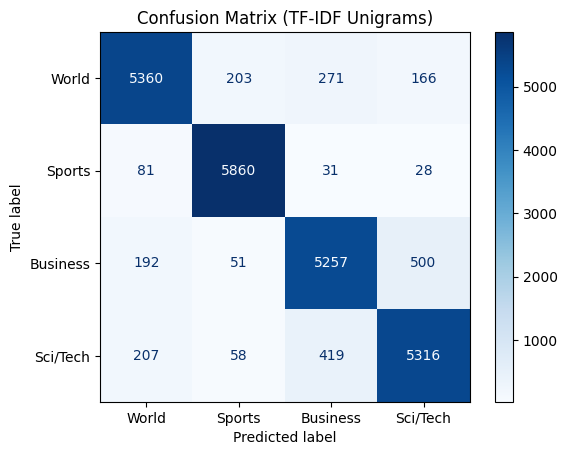

In [23]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Calculăm matricea de confuzie
cm_A2 = confusion_matrix(y_test, y_pred, labels=[0,1,2,3])

# 2. Nume umane pentru clase (în ordinea etichetelor 0,1,2,3)
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

# 3. Plot
disp_A2 = ConfusionMatrixDisplay(confusion_matrix=cm_A2,
                                 display_labels=class_names)

plt.figure(figsize=(6,5))
disp_A2.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (TF-IDF Unigrams)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()


In [24]:
# =============================
# AG_A3 — TF-IDF unigrams + bigrams
# =============================

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import (
    accuracy_score, precision_recall_fscore_support,
    classification_report
)

# Split consistent cu A1 / A2
train_df, test_df = train_test_split(
    ag,
    test_size=0.2,
    random_state=42,
    stratify=ag["label"]
)

vectorizer_A3 = TfidfVectorizer(
    max_features=20000,
    ngram_range=(1,2)   # unigrame + bigrame
)

X_train_A3 = vectorizer_A3.fit_transform(train_df["clean_text"])
X_test_A3  = vectorizer_A3.transform(test_df["clean_text"])

y_train_A3 = train_df["label"].values
y_test_A3  = test_df["label"].values

model_A3 = MultinomialNB(alpha=1.0)
model_A3.fit(X_train_A3, y_train_A3)

y_pred_A3 = model_A3.predict(X_test_A3)

# Metrici
acc_A3 = accuracy_score(y_test_A3, y_pred_A3)
prec_macro_A3, rec_macro_A3, f1_macro_A3, _ = precision_recall_fscore_support(
    y_test_A3, y_pred_A3, average="macro", zero_division=0
)
f1_weighted_A3 = precision_recall_fscore_support(
    y_test_A3, y_pred_A3, average="weighted", zero_division=0
)[2]

print({
    "Accuracy": round(acc_A3, 4),
    "Precision_macro": round(prec_macro_A3, 4),
    "Recall_macro": round(rec_macro_A3, 4),
    "F1_macro": round(f1_macro_A3, 4),
    "F1_weighted": round(f1_weighted_A3, 4)
})

print("\nClassification report – AG_A3 (TF-IDF unigrams + bigrams):\n")
print(classification_report(y_test_A3, y_pred_A3, digits=4))


{'Accuracy': 0.9101, 'Precision_macro': 0.9098, 'Recall_macro': 0.9101, 'F1_macro': 0.9098, 'F1_weighted': 0.9098}

Classification report – AG_A3 (TF-IDF unigrams + bigrams):

              precision    recall  f1-score   support

           0     0.9181    0.8973    0.9076      6000
           1     0.9497    0.9817    0.9654      6000
           2     0.8897    0.8672    0.8783      6000
           3     0.8815    0.8942    0.8878      6000

    accuracy                         0.9101     24000
   macro avg     0.9098    0.9101    0.9098     24000
weighted avg     0.9098    0.9101    0.9098     24000



<Figure size 600x500 with 0 Axes>

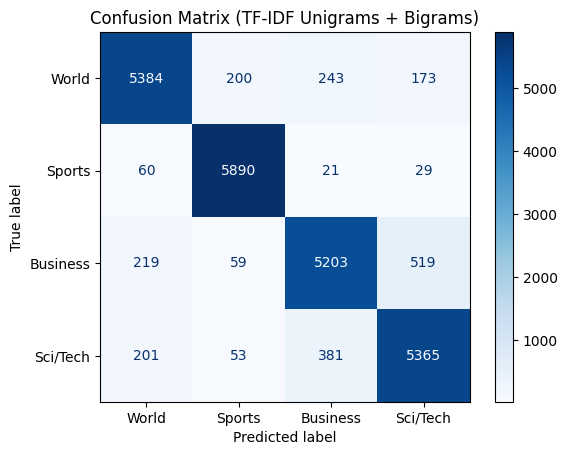

In [26]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt

# 1. Calculăm matricea de confuzie pentru A3
cm_A3 = confusion_matrix(y_test_A3, y_pred_A3, labels=[0,1,2,3])

# 2. Nume umane pentru clase
class_names = ['World', 'Sports', 'Business', 'Sci/Tech']

# 3. Plot
disp_A3 = ConfusionMatrixDisplay(confusion_matrix=cm_A3,
                                 display_labels=class_names)

plt.figure(figsize=(6,5))
disp_A3.plot(cmap='Blues', values_format='d')
plt.title("Confusion Matrix (TF-IDF Unigrams + Bigrams)")
plt.xlabel("Predicted label")
plt.ylabel("True label")
plt.show()
